## fit analysis

In [1]:
#include "DRCEventV5.h"
#include "functions.C"

In [3]:
#pragma cling add_library_path("/Users/justinvega/Documents/Fermilab/src/adriano_analysis/")
#pragma cling add_include_path("/Users/justinvega/Documents/Fermilab/src/adriano_analysis/")
//#pragma cling load("functions_C.so")

In [4]:
void FitWaveformFEBV1(Int_t RunNo, Int_t chlist, Int_t FirstEvent, TString path= "./ntup/", Bool_t debug=0, Int_t wfsize = 127, Int_t nfit = 1)
{

    const Int_t Nch=1;
    //Int_t chlist[Nch] = {19};

  gROOT->Reset();
  gStyle->SetOptFit(1111);
  new TMinuit;
  Int_t iconverge=0;

  TString sAnalysisDir(gSystem->pwd());

  TH1F *htmp = new TH1F("htmp","htmp",wfsize,0.,wfsize);

  const char *ext=".root";

  TString fname;
  string input = "";

  TSystemDirectory dir("data", path.Data());

  TList*files = dir.GetListOfFiles();


  Float_t BiasVoltage=-999., Energy=-999., cnt=-999., PartType=-999., Angle=-999., x=-999., z=-999., pressure=-999., DataWfSize=-999., RunBeginTime=-999., RunEndTime=-999., Gain1=-1., Gain2=-1.;

  if (files)
  {
    TSystemFile *file;
    TIter next(files);
    while ((file=(TSystemFile*)next())) {
      fname = file->GetName();
      if (!file->IsDirectory() && fname.EndsWith(ext)) {
	if(fname.BeginsWith(Form("RUN_%d_",RunNo)) || fname.BeginsWith(Form("RUN_FEB_%d_",RunNo)) || fname.BeginsWith(Form("RUN_TB4_%d_",RunNo)) ){
	  //cout << fname.Data() << endl;

	  input = fname.Data();

	  break;
	}
      }
    }
  }

  if((input.empty()))
  {
    cout << Form("\n\n $$ No Run %d in your data $$\n", RunNo);
    return;
  }

  Bool_t bad=0;
  if (!(fname.EndsWith(ext)) )
    bad=1;

  if(bad){
    cout << Form("RunNo: %d don't exist in data\n", RunNo);
    return;
  }

  fname.Prepend(path);
  string RootFileName = string(fname);


  //cout << Form("filename: %s RunNo: %d\n", RootFileName.data(), RunNo);
  TString sCurDir(gSystem->pwd());

  gSystem->cd(sAnalysisDir.Data());

  gSystem->cd(sCurDir.Data());



  //cout << gSystem->pwd() << endl;
  TFile f(Form("%s",RootFileName.data()));

  if(f.IsZombie()){
    f.Close();
    cout << Form("filename: %s RunNo: %d is bad\n", RootFileName.data(), RunNo);
    bad=1;
  }


  TTree *T1 = (TTree*)f.Get("DRCMB1");
  DRCEvent *event1 = 0;
  T1->SetBranchAddress("DRCEvent", &event1);

  TTree *T2 = (TTree*)f.Get("DRCMB2");
  DRCEvent *event2 = 0;
  T2->SetBranchAddress("DRCEvent", &event2);


  Int_t nEntriesMB1 = T1->GetEntries();
  Int_t nEntriesMB2 = T2->GetEntries();

  Int_t nEntries = TMath::Max(nEntriesMB1, nEntriesMB2);

  Int_t LastEvent = nEntries;
    
//   cout << Form("\n### Run: %d\n", RunNo);
//   cout << Form("\nMB1 has %d events   ###   ", nEntriesMB1);
//   cout << Form("MB2 has %d events\n", nEntriesMB2);

//   cout << "\nchannels selected: ";
//   for(Int_t j=0; j<Nch; j++)
//     cout << Form("%d ",  chlist[j]);

//   cout << "\n\nParameters:\nEnergy\tx\tz\tAngle\tBiasVoltage\tcounts\tPartType\tpressure\tGain1\tGain2\n";
//   cout << Form("%.0f\t%.0f\t%.0f\t%.0f\t%.1f\t\t%.0f\t%.0f\t\t%.1f\t\t%.0f\t\t%.0f", Energy, x, z, Angle, BiasVoltage, cnt, PartType, pressure, Gain1, Gain2);


  Int_t ChMaskMB1[32]={ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31};
  Int_t ChMaskMB2[32]={ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31};


  if( FirstEvent > nEntries ) FirstEvent = nEntries;

//   cout << Form("\n\nEvents to be processed: %d", FirstEvent);

//   cout << "\n\n";

//     TCanvas *grid = new TCanvas("grid", "grid", 600, 600);
//     int EventNo = 1;
    
  Int_t iEvt=FirstEvent; {
// for(Int_t iEvt=FirstEvent;iEvt<LastEvent;iEvt+=1000){

        Double_t dTime=-999.;

        Bool_t bIsNewEvent=1;

        //===============================

        for(Int_t iich=0;iich<Nch;iich++){

          Int_t ich = chlist;

          //       cout << Form("progress... %d%%   %d/%d   %d ch: %d\r", (Int_t)((iEvt-FirstEvent+1)*100/(LastEvent - FirstEvent)), (iEvt-FirstEvent+1), (LastEvent - FirstEvent), iEvt, ich) << flush;

          htmp->Reset();

          Int_t XMaxHisto = -999;
          Float_t XMaxFit = -999.;
          Double_t MaxVal1 = -999., MaxVal2 = -999.;
          Double_t Integral1 = -999., Integral2 = -999.;
          Double_t ped1=-999., ped2Left=-999., ped2Right=-999., sigma=-999.;
          Int_t ChCheck=0;


          DRCHit *drchit = 0x0;

          //***************** MB1 **********************//
          if(ich<16 && iEvt<nEntriesMB1){

            T1->GetEntry(iEvt);
            TClonesArray *DRCHits1=event1->GetDRCHits();
            if(!(DRCHits1->GetEntries())) continue;

            if(iEvt==FirstEvent){
              for(Int_t idxch=0; idxch<DRCHits1->GetEntries(); idxch++)
                ChMaskMB1[((DRCHit*)DRCHits1->At(idxch))->GetCh()] = idxch;
            }

            drchit = (DRCHit*)DRCHits1->At(ChMaskMB1[ich]);
            if(!drchit) continue;

              }


          //***************** MB2 **********************//
          else if(ich>15 && iEvt<nEntriesMB2){

        T2->GetEntry(iEvt);
        TClonesArray *DRCHits2=event2->GetDRCHits();
        if(!(DRCHits2->GetEntries())) continue;

        if(iEvt==FirstEvent)
        {
          for(Int_t idxch=0; idxch<DRCHits2->GetEntries(); idxch++){
            ChMaskMB2[((DRCHit*)DRCHits2->At(idxch))->GetCh()-16] = idxch;
          }
        }

        drchit = (DRCHit*)DRCHits2->At(ChMaskMB2[ich-16]);

        if(!drchit) continue;

          }

          for(Int_t i1=0;i1<wfsize;i1++){
        htmp->Fill(i1,(drchit->GetW().At(i1)));
          }

//           TF1 *fitsnr = new TF1("fitsnr",fitfn2,0.,wfsize,8);
//           // fitsnr->SetParameters(60., 2000.-2048.*bShift, -20000.,-0.05,-5000., -0.02,  -0.001, 2010.-2048.*bShift);
//               fitsnr->SetParameters(15., 5, 40000., -0.05, 20000., -0.02, -0.0001, -20);
//           for(int ifit=0;ifit<nfit;ifit++){
//             htmp->Fit("fitsnr", "BQ", "", 0., wfsize);
//             if(gMinuit->fEDM < 1.e-5) break;
              
//           }
//             Bool_t status = 0;
            
//             if(gMinuit->fCstatu.Contains("CONVERGED")){
//                 status = 1;
//                 iconverge++;
//           }
//             else{
//                 htmp->Reset();
//             }
            //cout << EventNo << endl;
                htmp->Draw("HIST");
                //fitsnr->Draw("SAME");
                htmp->SetTitle(Form("Fit Waveform for Run %d evt %d", RunNo, iEvt));
            //htmp->Reset();
              //fitsnr->Reset();
//             if (status == 1){
//           cout << Form("%d, ", iEvt);
//                 }
//             else{
//                 cout << Form("Run %d bad", iEvt) << endl;
//             }
          //cout<<status<<endl;
        }

        //if(debug) cout << endl;
      }

  //cout << endl;

  gSystem->cd(sAnalysisDir.Data());

  //cout<<iconverge<<endl;
//     grid->Modified();
//     grid->Update();
//     grid->Draw();
//     grid->SaveAs(Form("./fitpng/RUN_%d_evt_%d_fit.png",iRun, FirstEvent));
//     grid->Close();
}

In [15]:
int FirstEvent = 0;
int LastEvent = 60000;
int evtidx = 0;
TCanvas *grid1 = new TCanvas("grid1", "grid1", 1600, 900);
grid1->Divide(10, 6);
for(Int_t iEvt=FirstEvent;iEvt<LastEvent;iEvt+=1000){
    grid1->cd(evtidx+1);
    int iRun = 1025;
    FitWaveformFEBV1(iRun, iEvt);
    grid1->Modified();
    grid1->Draw();
    evtidx++;
}
grid1->Update();
//ch 3
// converged (9) 4000, 6000, 20000, 21000, 23000, 30000, 39000, 49000, 51000
// call limit (22) 3000, 5000, 7000, 9000, 15000, 19000, 25000, 26000, 28000, 29000, 33000, 35000, 36000, 37000, 38000, 40000, 41000, 43000, 48000, 53000, 54000, 59000
// failed (28) 0, 1000, 2000, 8000, 10000, 11000, 12000, 13000, 14000, 16000, 17000, 18000, 22000, 24000, 27000, 31000, 32000, 34000, 42000, 44000, 45000, 46000, 47000, 50000, 52000, 55000, 57000, 58000

Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid1
Warning in <TROOT::Append>: Replacing existing TH1: htmp (Potential memory leak).
Warning in <TFile::Init>: file ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root probably not closed, trying to recover
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB4 at address 243742461
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB1 at address 333134705
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB2 at address 339031809
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x131

In [16]:
grid1->SaveAs("./fitpng/RUN_1025_ch19_fit.pdf");

Info in <TCanvas::Print>: pdf file ./fitpng/RUN_1025_ch19_fit.pdf has been created


## one waveform

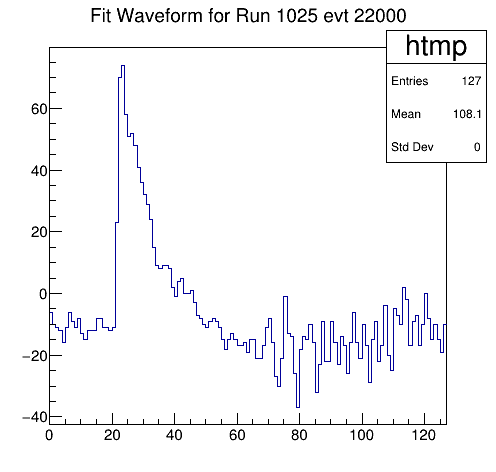

Warning in <TFile::Init>: file ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root probably not closed, trying to recover
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB4 at address 243742461
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB1 at address 333134705
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB2 at address 339031809
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB3 at address 342293565
Warning in <TFile::Init>: successfully recovered 4 keys


In [5]:
TCanvas *singlefit = new TCanvas("singlefit", "singlefit", 500, 500);
FitWaveformFEBV1(1025, 4, 22000);
singlefit->Draw();

## converged

In [18]:
%jsroot on
Int_t converged[] = {4000, 6000, 20000, 21000, 23000, 30000, 39000, 49000, 51000};
TCanvas *grid2 = new TCanvas("grid2", "grid2", 1000, 1000);
grid2->Divide(3, 3);
for(Int_t iEvt=0; iEvt<sizeof(converged)/sizeof(converged[0]);iEvt++){
    grid2->cd(iEvt+1);
    int iRun = 1025;
    FitWaveformFEBV1(iRun, converged[iEvt]);
    grid2->Modified();
    grid2->Draw();
}


Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid2
Warning in <TROOT::Append>: Replacing existing TH1: htmp (Potential memory leak).
Warning in <TFile::Init>: file ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root probably not closed, trying to recover
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB4 at address 243742461
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB1 at address 333134705
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB2 at address 339031809
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x131

## call limit

In [19]:
%jsroot on
Int_t call_limit[] = {3000, 5000, 7000, 9000, 15000, 19000, 25000, 26000, 28000, 29000, 33000, 35000, 36000, 37000, 38000, 40000, 41000, 43000, 48000, 53000, 54000, 59000};
TCanvas *grid3 = new TCanvas("grid3", "grid3", 1200, 600);
grid3->Divide(6, 4);
for(Int_t iEvt=0; iEvt<sizeof(call_limit)/sizeof(call_limit[0]);iEvt++){
    grid3->cd(iEvt+1);
    int iRun = 1025;
    FitWaveformFEBV1(iRun, call_limit[iEvt]);
    grid3->Modified();
    grid3->Draw();
}


Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid3
Warning in <TROOT::Append>: Replacing existing TH1: htmp (Potential memory leak).
Warning in <TFile::Init>: file ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root probably not closed, trying to recover
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB4 at address 243742461
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB1 at address 333134705
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB2 at address 339031809
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x131

## failed

In [20]:
%jsroot on
Int_t failed[] = {0, 1000, 2000, 8000, 10000, 11000, 12000, 13000, 14000, 16000, 17000, 18000, 22000, 24000, 27000, 31000, 32000, 34000, 42000, 44000, 45000, 46000, 47000, 50000, 52000, 55000, 57000, 58000};
TCanvas *grid4 = new TCanvas("grid4", "grid4", 1800, 900);
grid4->Divide(6, 4);
for(Int_t iEvt=0; iEvt<sizeof(failed)/sizeof(failed[0]);iEvt++){
    grid4->cd(iEvt+1);
    int iRun = 1025;
    FitWaveformFEBV1(iRun, failed[iEvt]);
    grid4->Modified();
    grid4->Draw();
}


Warning in <TCanvas::Constructor>: Deleting canvas with same name: grid4
Warning in <TROOT::Append>: Replacing existing TH1: htmp (Potential memory leak).
Warning in <TFile::Init>: file ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root probably not closed, trying to recover
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB4 at address 243742461
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB1 at address 333134705
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x1314_z286_psi.root, recovered key TTree:DRCMB2 at address 339031809
Info in <TFile::Recover>: ./ntup/RUN_FEB_1025_TB201912082159_120GeV_80Kcnt_54.4BV_900-900-900-900Gain_proton_0deg_x131

In [21]:
grid2->SaveAs("./fitpng/RUN_1025_fit_converged.pdf");
grid3->SaveAs("./fitpng/RUN_1025_fit_call-limit.pdf");


Info in <TCanvas::Print>: pdf file ./fitpng/RUN_1025_fit_converged.pdf has been created
Info in <TCanvas::Print>: pdf file ./fitpng/RUN_1025_fit_call-limit.pdf has been created


In [22]:
//grid2->SaveAs("./fitpng/RUN_1025_fit_converged.pdf");

In [23]:
grid4->SaveAs("./fitpng/RUN_1025_fit_failed.pdf");

Info in <TCanvas::Print>: pdf file ./fitpng/RUN_1025_fit_failed.pdf has been created
